In [1]:
# Import packages
import geopandas as gpd
import pandas as pd
from geopandas import overlay
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import random
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump, load
from sklearn.metrics import r2_score
import shap
from sklearn.inspection import PartialDependenceDisplay
import os
from IPython.display import display
from shapely.strtree import STRtree 
import os
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error

c:\Users\pamelama\micromamba\envs\geopython2023\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview: Random Forest suitability modelling (Local 50 m data)

This notebook demonstrates how to train and apply a **Random Forest (RF)** model to map potential sites for **in-stream wetland placement**, using **local data at 50 m resolution**.

It includes the full workflow:
- Preparing training data from wetland and non-wetland locations
- Extracting raster values at point locations
- Training the RF model and tuning hyperparameters
- Evaluating model performance
- Interpreting results using SHAP values
- Generating a continuous suitability map

📌 **Note**: While this notebook uses **local 50 m data**, you can follow the **same steps** for other data sources (e.g. global data, local data) and resolutions (e.g. 10 m, 50m), by adjusting the input raster files accordingly.


## Select existing wetlands that intersect with streams

This step identifies **existing wetlands** that are spatially connected to **streams or selected water bodies**. These intersecting wetlands are considered potential reference sites for in-stream wetland modelling.

**Procedure:**
- Load wetland polygons and water body features (lines and polygons) from the provided GeoPackage files.
- Correct invalid geometries using a zero-width buffer.
- Filter **linear water bodies** (e.g., rivers, streams, channels, main ditches) and **polygonal water bodies** (river polygon).
- Merge the selected water features into a single geometry collection.
- Filter wetlands by relevant types (e.g., *bog*, *quaking bog*, *swamp/mire*, *marshy grassland*).
- Select only those wetlands that **intersect** with the combined water body geometries.
- Export the final filtered wetland polygons to `wetlands_filtered_py.gpkg` .

This filtered layer represents known wetland areas that are spatially associated with streams and serves as the basis for generating training data.


In [ ]:
gpd.options.use_pygeos = True
data_directory = 'data'

# GeoPackage files
geopackages = {
    'wetlands': 'E_306_margala_a.gpkg',           # wetlands (Polygon)
    'water_bodies_lines': 'E_203_vooluveekogu_j.gpkg',    # water bodys (Line)
    'water_bodies_polygons': 'E_203_vooluveekogu_a.gpkg'  # water bodys (Polygon)
}
## Build full paths
geopackage_paths = {key: os.path.join(data_directory, filename) for key, filename in geopackages.items()}
# Load files
wetlands = gpd.read_file(geopackage_paths['wetlands'])
water_bodies_lines = gpd.read_file(geopackage_paths['water_bodies_lines'])
water_bodies_polygons = gpd.read_file(geopackage_paths['water_bodies_polygons'])

# same (CRS)
if wetlands.crs != water_bodies_lines.crs:
    water_bodies_lines = water_bodies_lines.to_crs(wetlands.crs)
if wetlands.crs != water_bodies_polygons.crs:
    water_bodies_polygons = water_bodies_polygons.to_crs(wetlands.crs)

# invalid geometries for wetlands and water_bodies_polygons
for df, name in [(wetlands, 'wetlands'), (water_bodies_polygons, 'water_bodies_polygons')]:
    invalid_geometries = ~df.is_valid
    if invalid_geometries.any():
        df.loc[invalid_geometries, 'geometry'] = df.loc[invalid_geometries, 'geometry'].buffer(0)
        print(f"Geometrías corregidas en {name}: {invalid_geometries.sum()}")
        
# Filter water bodies (lines) by type
water_bodies_lines_filtered = water_bodies_lines[
    (water_bodies_lines['type'].isin(['river', 'stream', 'channel', 'main ditch'])) |
    ((water_bodies_lines['type'] == 'ditch') & (water_bodies_lines['laius_t'] == '6-8 m'))
]

# Combine the water bodies (filtered lines and all polygons) into a single geometry
water_bodies_combined = gpd.GeoSeries(
    water_bodies_lines_filtered.geometry.tolist() + water_bodies_polygons.geometry.tolist(),
    crs=wetlands.crs
).explode(index_parts=False)  # each geometry is handle individually

# Filter wetlands by type
wetlands_filtered = wetlands[wetlands['type'].isin(['bog', 'quaking bog', 'swamp/mire', 'marshy grassland'])]

# Select only wetlands that intersect with water bodies
wetlands_intersected = wetlands_filtered[
    wetlands_filtered.geometry.apply(lambda geom: water_bodies_combined.intersects(geom).any())
]
# output export
output_path = 'wetlands_filtered_py.gpkg'  # save in directory
wetlands_intersected.to_file(output_path, driver="GPKG")
print(f"Number of polygons in the final GeoPackage layer: {len(wetlands_intersected)}")

C:\Users\pamelama\AppData\Local\ESRI\conda\envs\geopython\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Number of polygons in the final GeoPackage layer: 9182


## Stratified sampling of non-wetland polygons

To ensure a balanced dataset for model training, a **stratified random sample** is taken from the available **non-wetland polygons**. This sampling preserves the proportional representation of different land cover types within the non-wetland class, as defined by the `type` attribute. Since non-wetland polygons are more numerous than wetlands, we fix the **target sample size** to match the number of wetland polygons (**9182**) and distribute that total **proportionally across non-wetland classes**.

**Procedure:**
- Load the non-wetland polygon layer (`no_wetland_polygon.gpkg`).
- Verify that the `type` column is present (e.g., *arable land*, *forest*, *shrubland*, *grassland*).
- Calculate the relative frequency (percentage) of each class.
- Determine how many polygons to sample per class based on the target total count (e.g., **9182**, to match the number of existing wetlands).
- Randomly sample polygons within each class while maintaining their proportions.
- Save the result: `stratified_no_wetland_polygon.gpkg`.

This ensures that the non-wetland training data is **representative and balanced**, avoiding bias towards any single land cover class.

In [ ]:
def stratified_sampling(geopackage_path, output_path, target_count):
    # Load the GeoPackage
    gdf = gpd.read_file(geopackage_path)

    # Ensure the column 'type' exists
    if 'type' not in gdf.columns:
        raise ValueError("The input GeoPackage must have a 'type' column.")
    
    # Calculate the total count of polygons per class
    class_counts = gdf['type'].value_counts()
    total_polygons = len(gdf)
    # Calculate the percentage for each class
    class_percentages = class_counts / total_polygons
    print(class_percentages)
    # Determine the number of polygons to sample per class
    class_sample_sizes = (class_percentages * target_count).round().astype(int)

    # Perform stratified sampling
    sampled_gdfs = []
    for class_name, sample_size in class_sample_sizes.items():
        # Filter polygons by class
        class_gdf = gdf[gdf['type'] == class_name]
        # Randomly sample polygons
        sampled_class_gdf = class_gdf.sample(n=min(sample_size, len(class_gdf)), random_state=42)
        sampled_gdfs.append(sampled_class_gdf)

    # Combine sampled polygons
    sampled_gdf = gpd.GeoDataFrame(pd.concat(sampled_gdfs, ignore_index=True))

    # Save the sampled GeoPackage
    sampled_gdf.to_file(output_path, driver="GPKG")
    print(f"Sampled GeoPackage saved to {output_path}. Number of polygons: {len(sampled_gdf)}")

non_wetland_path = "data/no_wetland_polygon.gpkg"
output_path = "data/stratified_no_wetland_polygon.gpkg"
target_count = 9182  # Adjust the total number of polygons you want in the output (in this case same number that existing wetlands 9182)
stratified_sampling(no_wetland_path, output_path, target_count)

## Generating random points for wetland and non-wetland areas

This step generates a set of **random point samples** within the polygons representing wetlands and non-wetlands.

- For each polygon in the filtered wetland and non-wetland datasets, a fixed number of points (**30 per polygon**) is randomly placed **within the polygon boundary**.
- This results in a large number of spatially distributed points that reflect the underlying geometry of each class.

The output consists of two GeoPackage files:
- `wetland_points.gpkg`
- `no_wetland_points.gpkg`

These point layers will be used to extract raster values and train the suitability models.

In [ ]:
# Load the geopackage files
no_wetland = gpd.read_file("data/stratified_no_wetland_polygon.gpkg")
wetland_filtered = gpd.read_file('data/wetlands_filtered_py.gpkg')

# Function to generate n random points within a polygon
def generate_random_points_in_polygon(polygon, num_points):
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Generate random points for wetlands
wetland_points = []
for idx, row in wetland_filtered.iterrows():
    wetland_points.extend(generate_random_points_in_polygon(row['geometry'], 30))#30 number of point per polygon

# Generate random points for non-wetlands
no_wetland_points = []
for idx, row in no_wetland.iterrows():
    no_wetland_points.extend(generate_random_points_in_polygon(row['geometry'], 30))

# Print the number of points generated for each layer
print(f"Number of points generated for wetland_filtered: {len(wetland_points)}")
print(f"Number of points generated for no_wetland: {len(no_wetland_points)}")

# Convert points to GeoDataFrame
wetland_gdf = gpd.GeoDataFrame(geometry=wetland_points, crs=wetland_filtered.crs)
no_wetland_gdf = gpd.GeoDataFrame(geometry=no_wetland_points, crs=no_wetland.crs)

# Save points to GeoPackage 
wetland_sample=wetland_gdf
no_wetland_sample=no_wetland_gdf
wetland_sample.to_file('wetland_points.gpkg', driver="GPKG")
no_wetland_sample.to_file('no_wetland_points.gpkg', driver="GPKG")

print("Random points generated, balanced, and saved as GeoPackages.")

Number of points generated for wetland_filtered: 275460
Number of points generated for no_wetland: 275460
Random points generated, balanced, and saved as GeoPackages.


After generating the training points, two files are used:

- `wetland_points.gpkg`: point locations labeled as **wetlands**
- `no_wetland_points.gpkg`: point locations labeled as **non-wetlands**

These training points must remain **exactly the same** across all model configurations (e.g., local vs. global data, 10 m vs. 50 m resolution). This ensures a **consistent and fair comparison** between model outputs.

You only need to generate these points once. When switching between models or datasets, make sure to reuse the same `wetland_points.gpkg` and `no_wetland_points.gpkg` as input.

This applies to:
- AHP and RF models
- All resolutions (10 m and 50 m)
- All data sources (local and global)

## Extract values at point locations from Raster data

Replace the raster filenames below according to the resolution and data source you are using. The naming convention is as follows:

- Files ending with `_a.tif` refer to **local data** source
- Files ending with `_GEE_a.tif` refer to **global data** source (GEE)
- Resolutions include **10 m** and **50 m**

You must modify the file names according to your selected dataset:

| Variable     | Local 10 m                | Local 50 m                | Global 10 m               | Global 50 m               |
|--------------|---------------------------|---------------------------|---------------------------|---------------------------|
| **TWI**      | `twi_10m_a.tif`           | `twi_50m_a.tif`           | `twi_10m_GEE_a.tif`       | `twi_50m_GEE_a.tif`       |
| **Slope**    | `slope_10m_a.tif`         | `slope_50m_a.tif`         | `slope_10m_GEE_a.tif`     | `slope_50m_GEE_a.tif`     |
| **Clay**     | `clay_10m_a.tif`          | `clay_50m_a.tif`          | `clay_10m_GEE_a.tif`      | `clay_50m_GEE_a.tif`      |
| **SOC**      | `soc_10m_a.tif`           | `soc_50m_a.tif`           | `soc_10m_GEE_a.tif`       | `soc_50m_GEE_a.tif`       |
| **Flow Acc.**| `flow_acc_10m_a.tif`      | `flow_acc_50m_a.tif`      | `flow_acc_10m_GEE_a.tif`  | `flow_acc_50m_GEE_a.tif`  |


In [ ]:
##########VALUES AT POINT LOCATION FOR FILTERED WETLANDS ############################

data_directory = 'data'
# List of raster files
rasters = {
    'twi': 'twi_50m_a.tif',
    'slope': 'slope_50m_a.tif',
    'clay_soil': 'clay_50m_a.tif',
    'soc_soil': 'soc_50m_a.tif',
    'flow_acc': 'flow_acc_50m_a.tif', 
}
# Full file paths
raster_paths = {key: os.path.join(data_directory, filename) for key, filename in rasters.items()}

# Load data
points_gdf = gpd.read_file('wetland_points.gpkg')
points_gdf = points_gdf.set_crs('EPSG:3301') 

#empty list to start with the for loop for identify nodata
nodata_values_wet=[] 
# Assuming all rasters already share the same CRS and align with the points
for raster_name, raster_path in raster_paths.items():
    with rasterio.open(raster_path) as src:
        nodata_value = src.nodata
        nodata_values_wet.append((raster_name, nodata_value))
        
        print(f"Nodata value for {raster_name}: {src.nodata}")
        left, bottom, right, top = src.bounds
        
        # points_gdf = points_gdf.to_crs(src.crs)
        # Transform points if needed (just if they are in a different CRS)
        points_transformed = [(pt.x, pt.y) for pt in points_gdf.geometry]
        # Sample the raster at each point
        points_gdf[raster_name] = [x[0] for x in src.sample(points_transformed)]
        
# Save updated GeoDataFrame with all raster values as a new GeoPackage
points_gdf.to_file('values_wet.gpkg', driver="GPKG") #values for existing wetlands

display(points_gdf)
print(f"Updated number of points: {len(points_gdf)}")

Nodata value for twi: -99999.0
Nodata value for slope: None
Nodata value for clay_soil: None
Nodata value for soc_soil: None
Nodata value for flow_acc: None


,geometry,twi,slope,clay_soil,soc_soil,flow_acc
0,POINT (593964.663 6547141.320),11.544943,0.273249,60.0,27.107710,0.004431
1,POINT (593456.237 6549109.890),10.883250,0.416183,50.0,28.206890,0.007653
2,POINT (593781.989 6548180.108),10.924524,0.296897,50.0,28.206890,0.005335
3,POINT (592961.937 6548863.584),11.225744,0.335865,50.0,28.206890,0.020984
4,POINT (593532.435 6545407.299),8.905742,1.472340,50.0,28.394499,0.008640
...,...,...,...,...,...,...
275455,POINT (654741.263 6454006.637),8.236291,2.831963,9.0,4.265341,0.023037
275456,POINT (654545.130 6454021.705),9.719556,0.826388,70.0,27.527302,0.005402
275457,POINT (654449.622 6454069.890),6.782998,3.167549,9.0,4.265341,0.043203
275458,POINT (654719.637 6454018.005),8.297258,2.727671,9.0,4.265341,0.051069


Updated number of points: 275460


In [ ]:
###########VALUES AT POINTS LOCATION OF NO_WETLAND RANDOM POINTS(FOREST,ARABLE, SHRUBLAND,GRASSLAND) 
data_directory = 'data'

# List of raster files and their corresponding names in the GeoDataFrame
rasters = {
    'twi': 'twi_50m_a.tif',
    'slope': 'slope_50m_a.tif',
    'clay_soil': 'clay_50m_a.tif',
    'soc_soil': 'soc_50m_a.tif',
    'flow_acc': 'flow_acc_50m_a.tif',
}
# Full file paths
raster_paths = {key: os.path.join(data_directory, filename) for key, filename in rasters.items()}

# Load the shp into a GeoDataFrame
points_gdf = gpd.read_file('no_wetland_points.gpkg')
points_gdf = points_gdf.set_crs('EPSG:3301') 

print(f"Number of points in the dataset: {len(points_gdf)}")

nodata_values_no_wet=[]
# Assuming all rasters already share the same CRS and align with the points
for raster_name, raster_path in raster_paths.items():
    with rasterio.open(raster_path) as src:
        nodata_value = src.nodata
        nodata_values_no_wet.append((raster_name, nodata_value))
        
        print(f"Nodata value for {raster_name}: {src.nodata}")
        left, bottom, right, top = src.bounds
        
        # Transform points if needed (just if they are in a different CRS)
        points_transformed = [(pt.x, pt.y) for pt in points_gdf.geometry]

        # Sample the raster at each point
        points_gdf[raster_name] = [x[0] for x in src.sample(points_transformed)]

# Save the updated GeoDataFrame with all raster values as a new GeoPackage
points_gdf.to_file('values_no_wet.gpkg', driver="GPKG") #values for non-wetlands

display(points_gdf)
print(f"Updated number of points: {len(points_gdf)}")

Number of points in the dataset: 275460
Nodata value for twi: -99999.0
Nodata value for slope: None
Nodata value for clay_soil: None
Nodata value for soc_soil: None
Nodata value for flow_acc: None


,geometry,twi,slope,clay_soil,soc_soil,flow_acc
0,POINT (660461.298 6541003.238),6.878123,4.508321,15.0,1.898445,0.009919
1,POINT (660557.766 6541044.682),6.851404,4.704504,15.0,1.898445,0.029884
2,POINT (660506.475 6540998.510),5.582189,3.945074,15.0,3.817791,0.006929
3,POINT (660544.410 6541030.801),6.851404,4.704504,15.0,1.898445,0.029884
4,POINT (660536.044 6541023.499),6.851404,4.704504,15.0,1.898445,0.029884
...,...,...,...,...,...,...
275455,POINT (650290.944 6404771.067),11.734128,0.260698,70.0,26.205206,0.010154
275456,POINT (650333.167 6404762.309),11.044150,11.862318,70.0,26.205206,0.014877
275457,POINT (650281.813 6404767.264),11.781514,3.145533,70.0,26.205206,0.011422
275458,POINT (650335.924 6404750.100),11.044150,11.862318,70.0,26.205206,0.014877


Updated number of points: 275460


## Combine extracted values from wetland and non-wetland points

This step merges the values extracted from raster data at the locations of **wetland** and **non-wetland** points. A new attribute called **`suitability`** is added to each point:

- **`suitability = 1`** for wetlands (suitable locations)
- **`suitability = 0`** for non-wetlands (unsuitable locations)

The result is a single dataset that can be used to train and validate the suitability models.


In [68]:
# Load GeoPackage files
values_no_wetlands = gpd.read_file('values_no_wet.gpkg')
values_wetlands = gpd.read_file('values_wet.gpkg')

# Replace nodata values with np.nan in the GeoDataFrame(for wetlands)
for raster_name, nodata_value in nodata_values_wet:
    if nodata_value is not None:
        # Replace nodata values with NaN
        values_wetlands[raster_name] = values_wetlands[raster_name].replace(nodata_value, np.nan)
    # Replace negative values with NaN
    values_wetlands[raster_name] = values_wetlands[raster_name].apply(
        lambda x: np.nan if x < 0 else x
    )
# Replace nodata values with np.nan in the GeoDataFrame(for non wetlands)
for raster_name, nodata_value in nodata_values_no_wet:
    if nodata_value is not None:
        # Replace nodata values with NaN
        values_no_wetlands[raster_name] = values_no_wetlands[raster_name].replace(nodata_value, np.nan)
    # Replace negative values with NaN
    values_no_wetlands[raster_name] = values_no_wetlands[raster_name].apply(
        lambda x: np.nan if x < 0 else x
    )

# Remove any NaN values if necessary
values_no_wetlands = values_no_wetlands.dropna()
values_wetlands = values_wetlands.dropna()

# Assign suitability scores
values_wetlands['suitability'] = 1  # Wetlands have suitability score of 1
values_no_wetlands['suitability'] = 0  # Non wetlands have suitability score of 0

# Concatenate the datasets (wetlands and no wetlands)
concatenated = pd.concat([values_wetlands, values_no_wetlands], axis=0, ignore_index=True)

# Convert concatenated result into a GeoDataFrame
concatenated_dataframe = gpd.GeoDataFrame(concatenated)

# Select the correct columns based on what you have in your dataset
columns_to_keep = ['clay_soil', 'soc_soil', 'twi', 'slope','flow_acc' , 'suitability','geometry']
concatenated_dataframe = concatenated_dataframe[columns_to_keep]

# Display the number of records in each category
display(f"Number of records in 'values_wetlands': {len(values_wetlands)}")
display(f"Number of records in 'values_no_wetlands': {len(values_no_wetlands)}")
display(concatenated_dataframe.head(10))
concatenated_dataframe.to_file('values_concatenated.gpkg', driver='GPKG')
display("\nConcatenated GeoPackage saved as 'values_concatenated.gpkg'.")

"Number of records in 'values_wetlands': 249432"

"Number of records in 'values_no_wetlands': 260941"

,clay_soil,soc_soil,twi,slope,flow_acc,suitability,geometry
0,60.0,27.107710,11.544943,0.273249,0.004431,1,POINT (593964.663 6547141.320)
1,50.0,28.206890,10.883250,0.416183,0.007653,1,POINT (593456.237 6549109.890)
2,50.0,28.206890,10.924524,0.296897,0.005335,1,POINT (593781.989 6548180.108)
3,50.0,28.206890,11.225744,0.335865,0.020984,1,POINT (592961.937 6548863.584)
4,50.0,28.394499,8.905742,1.472340,0.008640,1,POINT (593532.435 6545407.299)
5,50.0,28.206890,10.869545,0.233983,0.004517,1,POINT (592834.449 6548612.838)
6,50.0,28.394499,9.381384,0.584860,0.004504,1,POINT (592665.716 6545712.222)
7,50.0,28.394499,8.657114,0.710751,0.004434,1,POINT (592494.528 6545618.265)
8,50.0,28.206890,10.925208,0.324450,0.012532,1,POINT (593839.325 6548055.319)
9,50.0,28.206890,10.465115,0.382947,0.004443,1,POINT (593060.169 6548852.738)


"\nConcatenated GeoPackage saved as 'values_concatenated.gpkg'."

In [9]:
### Load from here if everithing is already save before as GeoPackage
concatenated_dataframe= gpd.read_file('values_concatenated.gpkg')
print(f"Updated number of points: {len(concatenated_dataframe)}")

Updated number of points: 510373


In [10]:
display(concatenated_dataframe.tail(10))

,clay_soil,soc_soil,twi,slope,flow_acc,suitability,geometry
510363,9.0,3.395451,6.987205,5.214747,0.005501,0,POINT (650260.363 6404752.159)
510364,70.0,26.205206,11.044150,11.862318,0.014877,0,POINT (650339.931 6404747.784)
510365,70.0,26.205206,11.044150,11.862318,0.014877,0,POINT (650339.227 6404742.872)
510366,70.0,26.205206,11.734128,0.260698,0.010154,0,POINT (650314.138 6404771.861)
510367,70.0,26.205206,11.781514,3.145533,0.011422,0,POINT (650311.434 6404763.135)
510368,70.0,26.205206,11.734128,0.260698,0.010154,0,POINT (650290.944 6404771.067)
510369,70.0,26.205206,11.044150,11.862318,0.014877,0,POINT (650333.167 6404762.309)
510370,70.0,26.205206,11.781514,3.145533,0.011422,0,POINT (650281.813 6404767.264)
510371,70.0,26.205206,11.044150,11.862318,0.014877,0,POINT (650335.924 6404750.100)
510372,70.0,26.205206,11.781514,3.145533,0.011422,0,POINT (650295.142 6404745.907)


## Prepare Random Forest (RF) training and test sets

This step prepares the dataset for training and evaluating the Random Forest model.

- The combined dataset (with extracted raster values and `suitability` label) is split into **training** and **test** sets.
- 70% for training and 30% for testing.
- The `suitability` attribute is used as the target variable, while the remaining columns (e.g., TWI, slope, SOC, clay, flow accumulation) serve as predictors.

This allows the RF model to learn the patterns associated with suitable and unsuitable locations for in-stream wetlands.


In [11]:
# Read ML input
ml_input = concatenated_dataframe
display(ml_input.head(10))

,clay_soil,soc_soil,twi,slope,flow_acc,suitability,geometry
0,60.0,27.107710,11.544943,0.273249,0.004431,1,POINT (593964.663 6547141.320)
1,50.0,28.206890,10.883250,0.416183,0.007653,1,POINT (593456.237 6549109.890)
2,50.0,28.206890,10.924524,0.296897,0.005335,1,POINT (593781.989 6548180.108)
3,50.0,28.206890,11.225744,0.335865,0.020984,1,POINT (592961.937 6548863.584)
4,50.0,28.394499,8.905742,1.472340,0.008640,1,POINT (593532.435 6545407.299)
5,50.0,28.206890,10.869545,0.233983,0.004517,1,POINT (592834.449 6548612.838)
6,50.0,28.394499,9.381384,0.584860,0.004504,1,POINT (592665.716 6545712.222)
7,50.0,28.394499,8.657114,0.710751,0.004434,1,POINT (592494.528 6545618.265)
8,50.0,28.206890,10.925208,0.324450,0.012532,1,POINT (593839.325 6548055.319)
9,50.0,28.206890,10.465115,0.382947,0.004443,1,POINT (593060.169 6548852.738)


In [12]:
ml_input.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 510373 entries, 0 to 510372
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   clay_soil    510373 non-null  float64 
 1   soc_soil     510373 non-null  float64 
 2   twi          510373 non-null  float64 
 3   slope        510373 non-null  float64 
 4   flow_acc     510373 non-null  float64 
 5   suitability  510373 non-null  int64   
 6   geometry     510373 non-null  geometry
dtypes: float64(5), geometry(1), int64(1)
memory usage: 27.3 MB


C:\Users\pamelama\AppData\Local\Temp\ipykernel_23408\2146160345.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ml_input.iloc[:, 0:-2].hist(ax=ax)


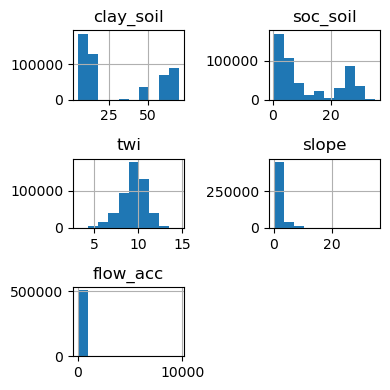

In [13]:
import matplotlib.pyplot as plt
# Plot histograms of features
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
#ml_input.hist(ax=ax)
ml_input.iloc[:, 0:-2].hist(ax=ax)
fig.tight_layout()

In [14]:
# Extract features and target
training_list=['flow_acc','soc_soil', 'clay_soil','slope', 'twi']
X = ml_input[training_list].copy() #5inputs
y = ml_input["suitability"].copy() # 1 output 2 classes

In [15]:
display(X)

,flow_acc,soc_soil,clay_soil,slope,twi
0,0.004431,27.107710,60.0,0.273249,11.544943
1,0.007653,28.206890,50.0,0.416183,10.883250
2,0.005335,28.206890,50.0,0.296897,10.924524
3,0.020984,28.206890,50.0,0.335865,11.225744
4,0.008640,28.394499,50.0,1.472340,8.905742
...,...,...,...,...,...
510368,0.010154,26.205206,70.0,0.260698,11.734128
510369,0.014877,26.205206,70.0,11.862318,11.044150
510370,0.011422,26.205206,70.0,3.145533,11.781514
510371,0.014877,26.205206,70.0,11.862318,11.044150


In [16]:
# Split the data into training and test sets
test_size = 0.3
random_state = 1
#random_state = 42 #optional 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [17]:
display(X_train)

,flow_acc,soc_soil,clay_soil,slope,twi
487296,0.025404,2.017676,9.0,1.276175,8.918134
109311,0.747857,18.920485,50.0,0.458904,11.256446
415939,0.038960,3.939021,15.0,2.179474,9.208361
332810,0.009761,3.168852,15.0,0.883363,9.103018
149001,0.004509,25.280907,70.0,0.250659,10.629447
...,...,...,...,...,...
491263,7.507565,24.890606,60.0,0.375406,10.370364
267336,0.113683,2.461422,35.0,0.693094,10.235429
470924,0.004591,3.547568,9.0,5.246291,5.294529
491755,0.005067,2.619899,5.0,0.305781,11.358109


### Hyperparameter tuning 

To improve model performance, we perform **hyperparameter tuning** on the Random Forest classifier using a **grid search** approach.

Key parameters optimised may include:
- `n_estimators`: number of trees in the forest
- `max_depth`: maximum depth of each tree
- `min_samples_split`: minimum number of samples required to split a node
- `min_samples_leaf`: minimum number of samples required at a leaf node
- `max_features`: number of features to consider when looking for the best split

A cross-validation strategy (e.g., 5-fold) is used to evaluate different parameter combinations, selecting the one that achieves the **highest validation accuracy**

In [31]:
# Number of trees in random forest
n_estimators = list(np.linspace(start=10, stop=250, num=50, dtype=int)) #stop=100

# Number of features to consider at every split
#max_features = [1, "sqrt", "log2"]
max_features=[1, 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = list(np.linspace(start=10, stop=250, num=50, dtype=int))
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20,30,40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,16,32]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create dictionary from parameters
param_distributions = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

In [32]:
%%time
# Perform search for hyperparameters
estimator = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=estimator, param_distributions=param_distributions, n_iter=200, verbose=2, random_state=random_state,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: total: 1min 51s
Wall time: 1h 28min 50s


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 14, 19, 24, 29, 34,
                                                      39, 44, 49, 54, 58, 63,
                                                      68, 73, 78, 83, 88, 93,
                                                      98, 103, 107, 112, 117,
                                                      122, 127, 132, 137, 142,
                                                      147, 152, ...],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16,
                                                             32],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [10, 14, 19, 24, 29, 34,
                                                         39, 44, 49, 54, 58, 63,
                                                         68, 73, 78, 83, 88, 93,
                                                         98, 103, 107, 112, 117,
                                                         122, 127, 132, 137,
                                                         142, 147, 152, ...]},
                   random_state=1, verbose=2)

In [33]:
print(len(X_train),len(X_test))

357261 153112


In [34]:
# Get best parameters
params = rf_random.best_params_
params["bootstrap"] = True
params["oob_score"] = True

print(rf_random)
print(params)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 14, 19, 24, 29, 34,
                                                      39, 44, 49, 54, 58, 63,
                                                      68, 73, 78, 83, 88, 93,
                                                      98, 103, 107, 112, 117,
                                                      122, 127, 132, 137, 142,
                                                      147, 152, ...],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16,
                                                             32],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                           

### Train model

In [35]:
# RF regressor
regressor = RandomForestRegressor()

In [36]:
params={}
params['n_estimators']=166
params['min_samples_split']= 2
params['min_samples_leaf']= 1
params['max_features']= 'log2'
params['max_depth']= 98
params["bootstrap"] = True
params["oob_score"] = True
print(params)

{'n_estimators': 166, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 98, 'bootstrap': True, 'oob_score': True}


In [37]:
# Set hyperparameters
regressor.set_params(**params)

RandomForestRegressor(max_depth=98, max_features='log2', n_estimators=166,
                      oob_score=True)

In [38]:
# Fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=98, max_features='log2', n_estimators=166,
                      oob_score=True)

In [39]:
# Calculate accuracy on training set
regressor.score(X_train, y_train)

0.9838011867227633

In [40]:
# Predict
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

In [41]:
r2_score(y_test, Y_test_pred)

0.8992814819164368

In [ ]:
## Mean Squared Error

In [ ]:
mse_train = mean_squared_error(y_train, Y_train_pred)
print("Mean Squared Error on Training Set:", mse_train)

In [ ]:
# Calculate MSE for the test set
mse_test = mean_squared_error(y_test, Y_test_pred)
print("Mean Squared Error on Test Set:", mse_test)

### Save RF model

In [94]:
#Save RF model
import joblib
joblib.dump(regressor, "ML_local_50m_final.joblib")

['ML_local_50m_final.joblib']

In [7]:
###Load RF model
#regressor = joblib.load("ML_local_50m_final.joblib")
regressor = joblib.load("ML_local_50m_final.joblib")

### SHAP (SHapley Additive exPlanations) values

SHAP values are used to interpret the output of the Random Forest model by quantifying the **contribution of each input variable** to the predicted suitability.

- SHAP provides **local explanations** (for individual predictions) and **global insights** (overall feature importance).
- The output includes summary plots showing which variables most influence the model’s suitability predictions.

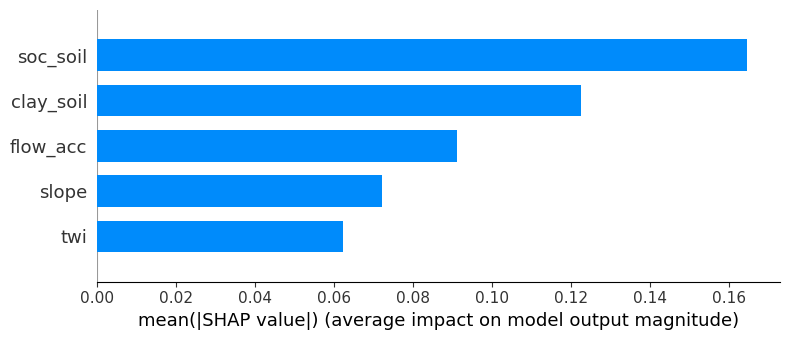

In [8]:
from joblib import Parallel, delayed
# Initialize SHAP explainer
explainer = shap.TreeExplainer(regressor)
# Function to compute SHAP values for a chunk
def compute_shap_chunk(X_chunk):
    return explainer.shap_values(X_chunk)  
    #return explainer.shap_values(X_chunk,approximate=True) # Use `approximate=True` to speed up

# Split data into 20 chunks and compute SHAP in parallel
num_jobs = 10  # Adjust based on CPU availability
X_chunks = np.array_split(X_train, num_jobs)
shap_values_list = Parallel(n_jobs=num_jobs, backend="loky")(
    delayed(compute_shap_chunk)(chunk) for chunk in X_chunks
)
# Concatenate the results back
shap_values = np.concatenate(shap_values_list, axis=0)
plt.figure()  # Explicitly create a new figure
# SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.savefig('shap_summary_plot.jpg', format='png', dpi=300)
plt.close()

In [9]:
# Convert SHAP values to a DataFrame for easier manipulation
shap_values_df = pd.DataFrame(shap_values, columns=['flow_acc', 'soc_soil', 'clay_soil', 'slope', 'twi'])
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = shap_values_df.abs().mean()
# Convert to a DataFrame for better readability
mean_abs_shap_values_df = mean_abs_shap_values.reset_index()
mean_abs_shap_values_df.columns = ['Feature', 'Mean Absolute SHAP Value']
# Sort by mean absolute SHAP value for better understanding
mean_abs_shap_values_df = mean_abs_shap_values_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

print(mean_abs_shap_values_df)

     Feature  Mean Absolute SHAP Value
1   soc_soil                  0.164573
2  clay_soil                  0.122540
0   flow_acc                  0.091072
3      slope                  0.072142
4        twi                  0.062310


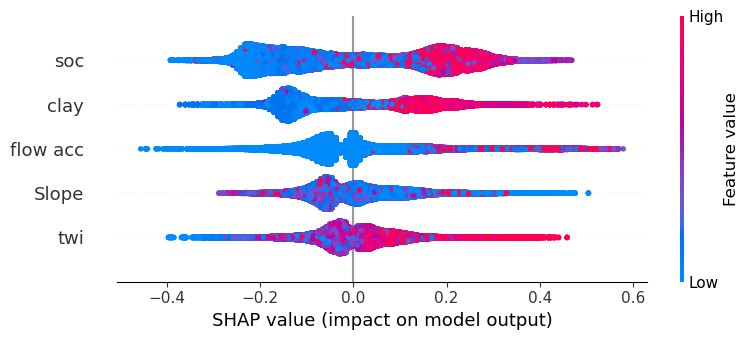

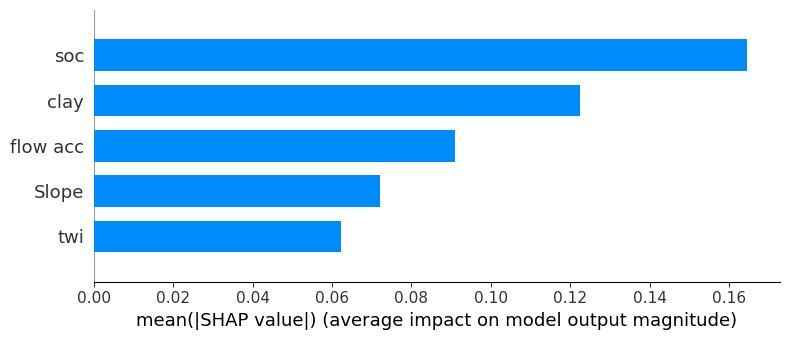

<Figure size 640x480 with 0 Axes>

In [10]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=['flow acc', 'soc', 'clay', 'Slope', 'twi'])
plt.tight_layout()

# SHAP summary bar plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=['flow acc', 'soc', 'clay', 'Slope', 'twi'], plot_type="bar")
plt.tight_layout()


## Suitability map creation

In this step, we apply the trained Random Forest model to the input raster layers in order to generate a **continuous suitability map**.

- The model is used to predict suitability scores (between 0 and 1) for every pixel in the study area based on the environmental variables (TWI, slope, SOC, clay, flow accumulation).
- The result is a raster map representing the **likelihood of wetland suitability**.

### Load data

In [ ]:
#raster to numpy array
data_directory='data' 
input_raster = data_directory+'mask_local_50m.tif'
# open raster with rasterio
with rasterio.open(input_raster) as src:
    # read the data with NumPy matrix 
    nan_mask = src.read(1)  # read the first band as NumPy matrix
    print("NumPy array dimensions:", nan_mask.shape)
    src.close()
print(nan_mask.dtype)

NumPy array dimensions: (5138, 7403)
float32


In [22]:
#raster to numpy array
input_raster = data_directory+'clay_50m_a.tif'
# open raster with rasterio
with rasterio.open(input_raster) as src:
    # read the data with NumPy matrix 
    clay_soil_array = src.read(1)  # read the first band as NumPy matrix
    print("NumPy array dimensions:", clay_soil_array.shape)
    print("min value:", np.nanmin(clay_soil_array))
    print("max value:", np.nanmax(clay_soil_array))
    src.close()
nan_mask[np.isnan(clay_soil_array)]=np.nan
clay_soil_array[np.isnan(clay_soil_array)] = -1
print(clay_soil_array.dtype)

NumPy array dimensions: (5138, 7403)
min value: 5.0
max value: 70.0
float32


In [23]:
#raster to numpy array
input_raster = data_directory+'soc_50m_a.tif'
# open raster with rasterio
with rasterio.open(input_raster) as src:
    # read the data with NumPy matrix 
    soc_soil_array = src.read(1)  # read the first band as NumPy matrix
    print("NumPy array dimensions:", soc_soil_array.shape)
    print("min value:", np.nanmin(soc_soil_array))
    print("max value:", np.nanmax(soc_soil_array))
    src.close()
nan_mask[np.isnan(soc_soil_array)]=np.nan
soc_soil_array[np.isnan(soc_soil_array)] = -1

NumPy array dimensions: (5138, 7403)
min value: 0.32780153
max value: 35.03709


In [24]:
#raster to numpy array
input_raster = data_directory+'flow_acc_50m_a.tif'
# open raster with rasterio
with rasterio.open(input_raster) as src:
    # read the data with NumPy matrix 
    flow_acc_array = src.read(1)  # read the first band as NumPy matrix
    print("NumPy array dimensions:", flow_acc_array.shape)
    print("min value:", np.nanmin(flow_acc_array))
    print("max value:", np.nanmax(flow_acc_array))
    src.close()
nan_mask[np.isnan(flow_acc_array)]=np.nan
flow_acc_array[np.isnan(flow_acc_array)] = -1

NumPy array dimensions: (5138, 7403)
min value: -3195.4011
max value: 55781.043


In [25]:
#raster to numpy array
input_raster = data_directory+'slope_50m_a.tif'
# open raster with rasterio
with rasterio.open(input_raster) as src:
    # read the data with NumPy matrix 
    slope_array = src.read(1)  # read the first band as NumPy matrix
    print("NumPy array dimensions:", slope_array.shape)
    print("min value:", np.nanmin(slope_array))
    print("max value:", np.nanmax(slope_array))
    src.close()
nan_mask[np.isnan(slope_array)]=np.nan
slope_array[np.isnan(slope_array)] = -1

NumPy array dimensions: (5138, 7403)
min value: 0.0
max value: 50.3417


In [26]:
#raster to numpy array
input_raster = data_directory+'twi_50m_a.tif'
# open raster with rasterio
with rasterio.open(input_raster) as src:
    # read the data with NumPy matrix 
    twi_array = src.read(1)  # read the first band as NumPy matrix
    print("NumPy array dimensions:", twi_array.shape)
    print("min value:", np.nanmin(twi_array))
    print("max value:", np.nanmax(twi_array))
    src.close()
nan_mask[np.isnan(twi_array)]=np.nan
twi_array[np.isnan(twi_array)] = -1

NumPy array dimensions: (5138, 7403)
min value: -99999.0
max value: 16.41423


### Running map generation(with parallel processing)

we process the raster data in **chunks** using **parallel computing** (`joblib`).

**Key steps:**
- The input rasters (e.g. TWI, slope, SOC, clay, flow accumulation) are split into horizontal chunks.
- Each chunk is reshaped and passed to the trained model for prediction.
- Predictions from all chunks are combined and reshaped to form a complete 2D suitability map.
- The resulting raster is saved as a GeoTIFF (`ML_suitability_50m_local_final.tif`) with the original spatial reference and resolution.

This approach speeds up computation on large raster datasets while maintaining full spatial coverage. The output is a continuous map of predicted suitability values across the landscape.


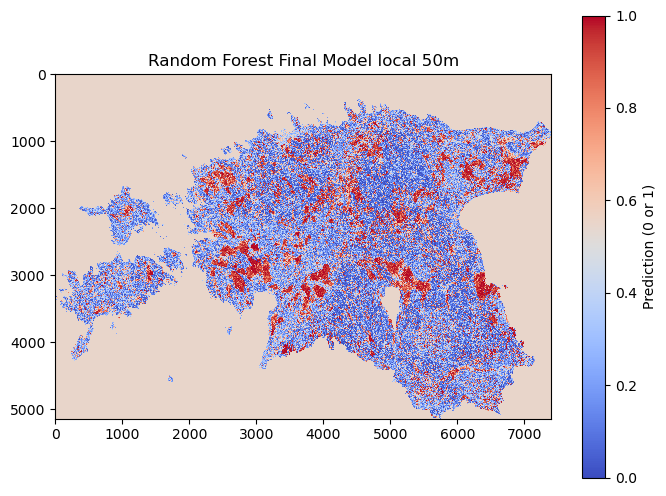

In [29]:
## Parallel Processing
from joblib import Parallel, delayed

# Assuming flow_acc_array and other arrays are large 2D arrays
chunk_size = 1000 # Define the chunk size (e.g., process 1000 rows at a time)
num_rows = flow_acc_array.shape[0]
# Calculate the number of chunks
num_chunks = int(np.ceil(num_rows / chunk_size))
def process_chunk(start_row, end_row):
    # Extract the chunk for each array
    flow_acc_chunk = flow_acc_array[start_row:end_row, :]
    soc_soil_chunk = soc_soil_array[start_row:end_row, :]
    clay_soil_chunk = clay_soil_array[start_row:end_row, :]
    slope_chunk = slope_array[start_row:end_row, :]
    twi_chunk = twi_array[start_row:end_row, :]
    # Reshape each chunk into 1D arrays
    arrays_reshaped = [arr.ravel() for arr in [flow_acc_chunk, soc_soil_chunk,
                                               clay_soil_chunk, slope_chunk, twi_chunk]]
    # Stack arrays horizontally
    data_chunk = np.column_stack(arrays_reshaped)
    # Predict using the RF model
    predictions_chunk = regressor.predict(data_chunk)
    return predictions_chunk

# Create a list of start and end indices for each chunk
indices = [(i * chunk_size, min((i + 1) * chunk_size, num_rows)) for i in range(num_chunks)]
# Process chunks in parallel
predictions_list = Parallel(n_jobs=-1)(delayed(process_chunk)(start, end) for start, end in indices)
# Concatenate the predictions from all chunks
predictions = np.concatenate(predictions_list)
# Reshape the predictions back to the original 2D shape
predictions_2d = predictions.reshape(flow_acc_array.shape)
# Visualizing
plt.figure(figsize=(8, 6))
plt.imshow(predictions_2d, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Prediction (0 or 1)')
plt.title('Random Forest Final Model local 50m')
plt.show()

In [30]:
#Save suitability map
src = rasterio.open(data_directory+'flow_acc_50m_GEE_a.tif')
transform = src.transform
output_raster_path = 'ML_suitability_50m_local_final.tif'
# new raster using rasterio
predictions_2d[np.isnan(nan_mask)]=np.nan
with rasterio.open(output_raster_path, 'w', driver='GTiff',
                   height=predictions_2d.shape[0], width=predictions_2d.shape[1],
                   count=1, dtype=predictions_2d.dtype,
                   crs=src.crs, transform=transform, compress='LZW') as dst:
#write the NumPy matrix in the new raster
    dst.write(predictions_2d, 1)
    dst.close()
#show data
#dataset= rasterio.open(output_raster_path)
#show(dataset)